In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.spatial import distance_matrix
%matplotlib inline

This script automatically detect game features from a perfect game image. Using OpenCV and further processing using clustering techniques, game dimensions, squares coordinates and tree locations are detected. There are several hyperparamters required for the line detection, these parameters are manually tuned to find all game lines in the input figure. The extracted game dimesion and tree locations can be direct input for the tents_n_trees script that automatically solves the game.

1. Detect grid lines using Hough line detection and DBScan clustering
4. Obtain line intersections and block coordinates
5. Detect trees using pixel intensities and K-means clustering

Let's begin and load an game image and convert it to black and white for easy processing.

(745, 750, 3)


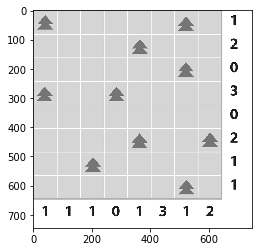

In [2]:
img = cv2.imread('example.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print(img.shape)
plt.imshow(gray, cmap='gray');

### Grid line detection

First we blur the image to remove noise and use Canny edge detection to detect edges in the figure. Next Hough Line detection is applied to detect lines from the edges. This approach requires a bunch of parameters to be set. The parameters are hand tuned to work for this particular image, these might require further optimization to work for other images.

#### Parameters
- **kernel_size** (int) = Size of the gaussian kernal use to smooth the image.
- **high_threshold** (int) = intensity gradient above which pixels are certainly classified as edge.
- **low_threshold** (int) =  pixel with an intensity gradient below the min treshold cannot be edges, pixels between both thresholds are only classified as edges if connected to pixels above the high threshold

- **rho** (int) =
- **theta** (float) =
- **thershold** (int) = 
- **min_line_lenght** (int) = 
- **max_line_gap (int) = 

In [3]:
kernel_size = 11
high_threshold = 10
low_threshold = 5

rho = 3  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 20  # minimum number of votes (intersections in Hough grid cell)
min_line_length = img.shape[0]*0.8  # minimum number of pixels making up a line
max_line_gap = img.shape[0]*0.05 # maximum gap in pixels between connectable line segments


blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap).reshape(-1,4)

print(f'we find {len(lines)} lines')

we find 26 lines


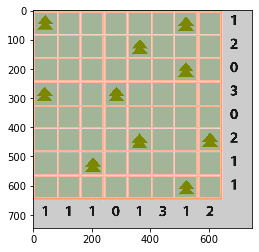

In [4]:
def visualize_lines(lines, img):
    line_image = np.copy(img) * 0  # creating a blank to draw lines on
    for x1,y1,x2,y2 in lines:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)

    # Draw the lines on the  image
    lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)
    plt.imshow(lines_edges, cmap='gray');
    
visualize_lines(lines, img)

It seems that we find to many lines, there should only be 9 + 9 lines. Let's deduplicate lines by assigning similar lines to a cluster and pick only a single line per cluster. The number of cluster should be equal to the number of lines we should end up with. However, we do not know the required number of lines, and thus the number of clusters. Therefore we use DBSCAN clustering, this clustering method is able to determine an optimal number of clusters automatically.

In [5]:
from sklearn.cluster import DBSCAN

# Set up something smart to automatically determine eps

dbscan = DBSCAN(eps=50, min_samples=1)
cluster_ids = dbscan.fit_predict(lines.reshape(-1,4))
cleaned_lines = lines[np.unique(cluster_ids, return_index=True)[1]]
len(cleaned_lines)

18

Yay! We find the required 18 grid lines, let's inspect the lines to be sure that we got all of them:

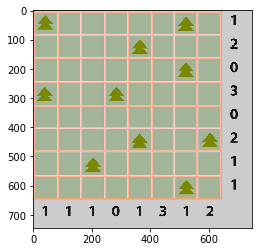

In [6]:
visualize_lines(cleaned_lines, img)

### Obtain line intersections and block coordinates
Now we can use our lines to find coordinates of the line intersections, in our example we expect to fine 9 * 9 = 81 intersections. With these intersections we can create coordinates for each square in the image.

1. Split lines in horizontal and vertical lines.
2. Find intersections between horizontal and vertical lines.
3. Use intersections to get coordinates of each block

In [7]:
# Select horzontal and vertical lines
# Reshape lines to [n_lines,start_x_y_coordinates,end_x_y_coordinates]
cleaned_lines = cleaned_lines.reshape(-1,2,2)

hor_lines = cleaned_lines[np.diff(cleaned_lines[:,:,0]).reshape(-1) == 0]
ver_lines = cleaned_lines[np.diff(cleaned_lines[:,:,1]).reshape(-1) == 0]

len(hor_lines), len(ver_lines)

(9, 9)

In [8]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return np.array([[x, y]]).astype('int')

In [9]:
# Initiate an empty array with shape [n_intersections,xy_coordinates]

n_intersections = len(hor_lines) * len(ver_lines)
intersections = np.zeros(shape=(n_intersections,2))

i = 0
for hor_line in hor_lines:
    for ver_line in ver_lines:
        intersections[i] = line_intersection(hor_line, ver_line)
        i += 1
        
print(f'We find {len(intersections)} intersections')

We find 81 intersections


To define a block, we have to set the top left and bottom right coordinates. We do such as for each intersection:
1. Assume the intersection is the top left intersection of our block. 
2. Find the closest intersection that is not on the same x or y location using eucledean distance. This intersection is the bottom right coordinate.

In [10]:
n_blocks = (len(hor_lines)-1) * (len(ver_lines)-1)

blocks = np.empty(shape=(n_blocks,4), dtype='int')

idx = 0
for intersection in intersections:
    intersections_diff = intersections - intersection
    
    # Exclude intersections that are on the same x or y axis
    potentials = intersections[(intersections_diff[:,0] > 0) &
                               (intersections_diff[:,1] > 0)]
    
    # Select the closest intersection
    closest_idx = np.argsort(np.sum((potentials - intersection)**2, axis=1))
    
    if len(closest_idx) > 0:
        block = np.concatenate(([potentials[closest_idx[0]]], [intersection]), axis=0).reshape(4)
        
         # Assign and reorder indices to x1, x2, y1, y2
        blocks[idx] = block[[3,1,2,0]]
        idx += 1
        
blocks[:3]

array([[482, 567, 245, 326],
       [246, 326, 245, 326],
       [  5,  85, 245, 326]])

## Determine which blocks contains a tree

Using the average pixel intesity is a very simple approach to determine whether a block contains a tree or not. The mean pixel intensity histogram shows that the game blocks are split in 2 distinct groups. It seems that the group with lower pixel intensity values contains 10 squares, which is exactly the number of trees in the game. 

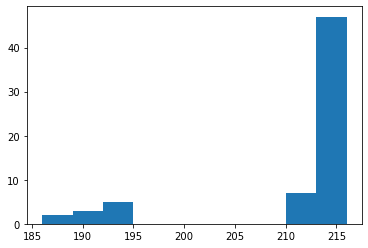

In [11]:
def mean_intensity(block):
    """Calculate the mean pixel intensity for a block"""
    x1, x2, y1, y2 = block
    area_of_interest = gray[y1:y2, x1:x2]
    return np.mean(area_of_interest).astype('int')

# Calculate the mean pixel intesity for each square of the game.
block_intensity = np.apply_along_axis(mean_intensity, 1, blocks)

plt.hist(block_intensity);

Let's use K-means clustering to automatically separate squares in 2 groups.

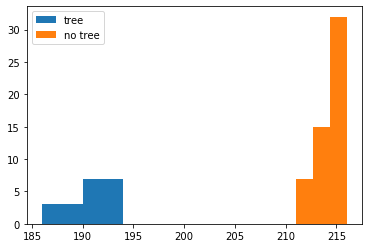

In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 2)
tree_flag = kmeans.fit_predict(block_intensity.reshape(-1,1)).astype('int')

# Add whether the square contains a tree to our blocks array
# The shape of the array is [n_blocks,[x1,x2,y1,y2,mean_intensity,tree_flag]]

blocks_trees = np.concatenate([blocks, block_intensity.reshape(-1,1), tree_flag.reshape(-1,1)], axis=1)

trees = blocks_trees[(blocks_trees[:,5] == 1)]
no_trees = blocks_trees[~(blocks_trees[:,5] == 1)]
plt.hist(trees[:,4], label='tree', bins=2)
plt.hist(no_trees[:,4], label='no tree', bins=3)
plt.legend();

In [13]:
# Assign blocks to a 2d array
dimension = int(np.sqrt(len(blocks_trees)))
blocks_2d = blocks_trees[np.lexsort((blocks_trees[:,2],blocks_trees[:,0]))].reshape(dimension,dimension,6)

This block contains 1 Tree


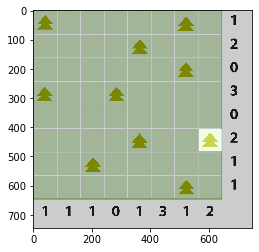

In [14]:
# # Draw an example block with xmas tree
def draw_block(game_fig, blocks_2d, x, y):
    
    # Initiate a empty array
    blocks_image = np.copy(game_fig) * 0
    # Extract coordinates for the square
    x1,x2,y1,y2,intensity,tree_flag = blocks_2d[x,y]
    # Set pixels to max value
    blocks_image[y1:y2,x1:x2] = 255
    temp = cv2.addWeighted(game_fig, 0.8, blocks_image, 0.3, 0)
    print(f'This block contains {tree_flag} Tree')
    plt.imshow(temp);

x, y = 7,5
draw_block(img, blocks_2d, x, y)